In [1]:
# import necessary modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualisation
import matplotlib.pyplot as plt # plot
import os
import re

pd.options.display.max_columns=500

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures, StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA


In [2]:
#Read the file
fifa=pd.read_csv('fifadata.csv',index_col=0)
pd.set_option('display.max_columns',100)
#fifa.head()

In [3]:
#cleaning columns
cc=['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW','LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

for i in cc:
    fifa[i]=fifa[i].str.split('+',n=1,expand=True)[0]
    fifa[i]=pd.to_numeric(fifa[i])

In [4]:
# combine the position attributes as per pitch area
fifa['Forward'] = fifa.loc[:,'LS':'RW'].astype('float64').mean(axis=1)
fifa['Midfield'] = fifa.loc[:,'LAM':'RM'].astype('float64').mean(axis=1)
fifa['Defense'] = fifa.loc[:,'LWB':'RB'].astype('float64').mean(axis=1)
fifa['GoalKeeper'] = fifa.loc[:,'GKDiving':'GKReflexes'].astype('float64').mean(axis=1)

# drop the columns that are replaced above
fifa.drop(fifa.loc[:,'LS':'RB'].columns.tolist(), axis=1, inplace=True)
fifa.drop(fifa.loc[:,'GKDiving':'GKReflexes'].columns.tolist(), axis=1, inplace=True)

In [5]:
fifa["Club"].fillna("Freelance", inplace = True) 

In [6]:
#renaming columns
colnew = []

for col in fifa.columns:
    colnew.append(col.replace(' ', ''))
    
fifa.columns = colnew

In [7]:
fifa.Wage=fifa.Wage.replace(['M', 'K', '€|\.'], ['000000', '000', ''], regex = True)
fifa.Wage=fifa.Wage.astype('int64')

In [8]:
def cleaning_value(x):
    if '€' in str(x) and 'M' in str(x):
        c = str(x).replace('€' , '')
        c = str(c).replace('M' , '')
        c = float(c) * 1000000
        
    else:
        c = str(x).replace('€' , '')
        c = str(c).replace('K' , '')
        c = float(c) * 1000
            
    return c

fn = lambda x : cleaning_value(x)

fifa['VALUE'] = fifa['Value'].apply(fn)
fifa.VALUE=fifa.VALUE.astype('int64')

fifa=fifa.drop('Value', axis=1)

In [9]:
# Cleaning columns
fifa['Weight']=fifa['Weight'].str.replace('lbs','')
fifa['Height']=fifa['Height'].str.replace("'",'.')

# Changing datatypes from Object to float
fifa.Height = fifa.Height.astype(float)
fifa.Weight = fifa.Weight.astype(float)

In [10]:
#Split the Work Rate Column in two
tempwork = fifa["WorkRate"].str.split("/ ", n = 1, expand = True) 
#Create new column for first work rate
fifa["WorkrateAttack"]= tempwork[0]   
#Create new column for second work rate
fifa["WorkrateDefense"]= tempwork[1]

fifa=fifa.drop('WorkRate', axis=1)

In [11]:
fifa['BodyType']=fifa['BodyType'].str.replace('Messi','Lean')
fifa['BodyType']=fifa['BodyType'].str.replace('Neymar','Normal')
fifa['BodyType']=fifa['BodyType'].str.replace('Courtois','Normal')
fifa['BodyType']=fifa['BodyType'].str.replace('C. Ronaldo','Lean')
fifa['BodyType']=fifa['BodyType'].str.replace('PLAYER_BODY_TYPE_25','Stocky')
fifa['BodyType']=fifa['BodyType'].str.replace('Akinfenwa','Stocky')
fifa['BodyType']=fifa['BodyType'].str.replace('Shaqiri','Stocky')

In [12]:
# removing the columns that do not provide any additional information
fifa.drop(['ID','Photo','Name','RealFace','Flag','LoanedFrom','ClubLogo','JerseyNumber','ReleaseClause', 
           'Joined','ContractValidUntil','Club','Nationality'], inplace=True, axis=1)

In [13]:
fifa.dropna(axis=0,how='all' ,subset=['Finishing'], inplace=True)

In [14]:
# imputing data in Position column based on Player attributes that can help us identify which position is suitable for the player 

from sklearn.tree import DecisionTreeClassifier

col = fifa.loc[:,'Crossing':'SlidingTackle'].columns
# filter data for model building
X = fifa[col][fifa['Position'].notna()]
y = fifa.Position[fifa['Position'].notna()]

# create test data with unknown fuelType fields
xt = fifa[col][fifa['Position'].isna()]
        
# build a decision tree model
dtree = DecisionTreeClassifier().fit(X,y)

# predict on test data
pos_pred = dtree.predict(xt)

# fill the missing values with the predicted values
fifa.Position[fifa['Position'].isna()] = pos_pred
# fifa.Position.isna().sum()

In [ ]:
# fwd = ['Crossing', 'Finishing', 'ShortPassing', 'Dribbling', 'Curve', 'FKAccuracy', 'Acceleration', 
#        'SprintSpeed', 'ShotPower', 'BallControl', 'Penalties']
# mid = ['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 
#        'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 
#        'Balance','ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 
#        'Positioning', 'Vision', 'Penalties']
# des = ['Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'Jumping', 'Stamina', 'Strength', 
#        'LongShots', 'HeadingAccuracy']

# x = fifa[fwd][fifa['Forward'].isna()].mean(axis=1).astype('int64')
# fifa.Forward[fifa['Forward'].isna()] = x

# x = fifa[mid][fifa['Midfield'].isna()].mean(axis=1).astype('int64')
# fifa.Midfield[fifa['Midfield'].isna()] = x

# x = fifa[des][fifa['Defense'].isna()].mean(axis=1).astype('int64')
# fifa.Defense[fifa['Defense'].isna()] = x

In [15]:
fifa.dropna(axis=0,inplace=True)

In [18]:
#fifa.isna().sum()

In [25]:
# Checking Co-relations
ad=fifa.corr()
ad.style.background_gradient(cmap='coolwarm')

# fifa=fifa.drop(['Midfield','Dribbling','BallControl','Special','LongShots','Positioning','Interceptions','SkillMoves','Forward',
#                 'Crossing','ShortPassing'], axis=1)

In [20]:
fifa=fifa.dropna(axis=0)

In [16]:
# One Hot Encoding Categorical Variables

fifa=pd.concat([pd.get_dummies(fifa['PreferredFoot']),fifa],axis=1).drop('PreferredFoot',axis=1)
fifa=pd.concat([pd.get_dummies(fifa['BodyType']),fifa],axis=1).drop('BodyType',axis=1)
fifa=pd.concat([pd.get_dummies(fifa['WorkrateAttack']),fifa],axis=1).drop('WorkrateAttack',axis=1)
fifa=pd.concat([pd.get_dummies(fifa['WorkrateDefense']),fifa],axis=1).drop('WorkrateDefense',axis=1)
fifa=pd.concat([pd.get_dummies(fifa['Position']),fifa],axis=1).drop('Position',axis=1)
#fifa=pd.concat([pd.get_dummies(fifa['Nationality']),fifa],axis=1).drop('Nationality',axis=1)
#fifa=pd.concat([pd.get_dummies(fifa['Club']),fifa],axis=1).drop('Club',axis=1)

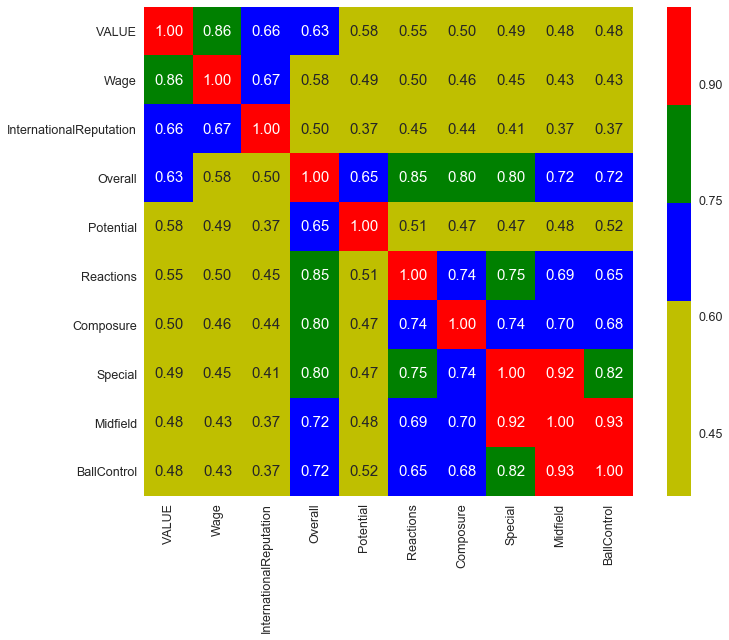

In [23]:
corr_mat = fifa.corr()
k=10
plt.figure(figsize=(12,9))
cols = corr_mat.nlargest(k, 'VALUE')['VALUE'].index
cm = np.corrcoef(fifa[cols].values.T)
sns.set(font_scale=1.25)
sns.heatmap(cm, annot=True, fmt='.2f', annot_kws={'size':15}, yticklabels=cols.values, xticklabels=cols.values, cmap=['y','y','b','g','r'], square=True)
plt.show()

In [19]:
fifa.shape

(15918, 81)

In [18]:
fifa=fifa[fifa.VALUE > 0]

In [20]:
fifa.skew().sort_values(ascending=False)[:10]

LF     32.533066
RF     31.497031
RAM    27.479877
LAM    27.479877
CF     14.565465
LWB    14.181670
RWB    13.416592
RS      8.730474
LS      8.619684
LDM     7.976826
dtype: float64

In [21]:
from scipy import stats

Value skew:  6.949720137704822
Value skew:  0.41554987751512423


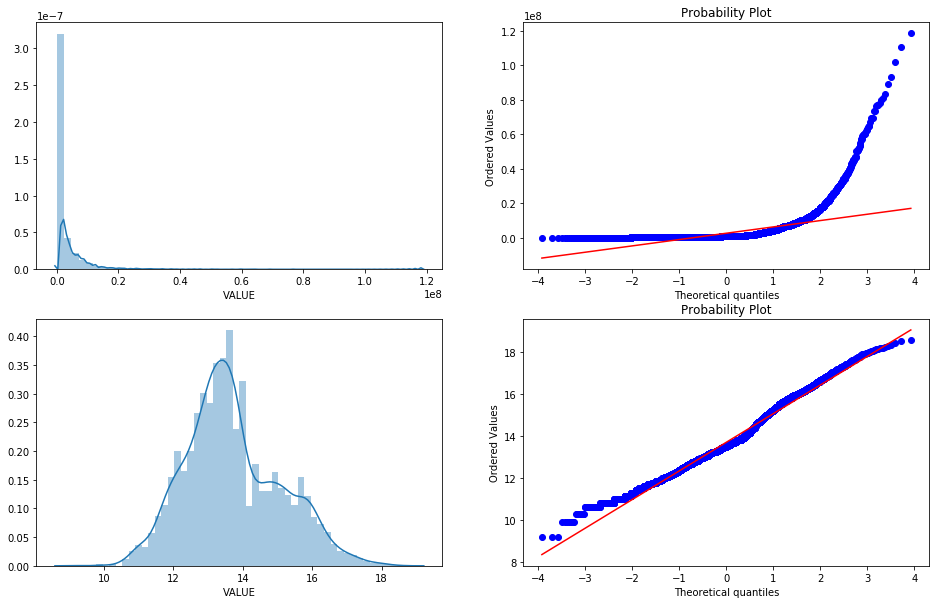

In [22]:
plt.subplots(figsize=(16,10))
plt.subplot(221)
sns.distplot(fifa['VALUE'])
print('Value skew: ',fifa.VALUE.skew())

plt.subplot(223)
d=np.log1p(fifa['VALUE'])
sns.distplot(d)
print('Value skew: ',d.skew())

plt.subplot(222)
stats.probplot(fifa.VALUE, plot=plt)

plt.subplot(224)
stats.probplot(d, plot=plt)


plt.show()

Wage skew:  7.801550711225325
Wage skew:  0.6893276290206956


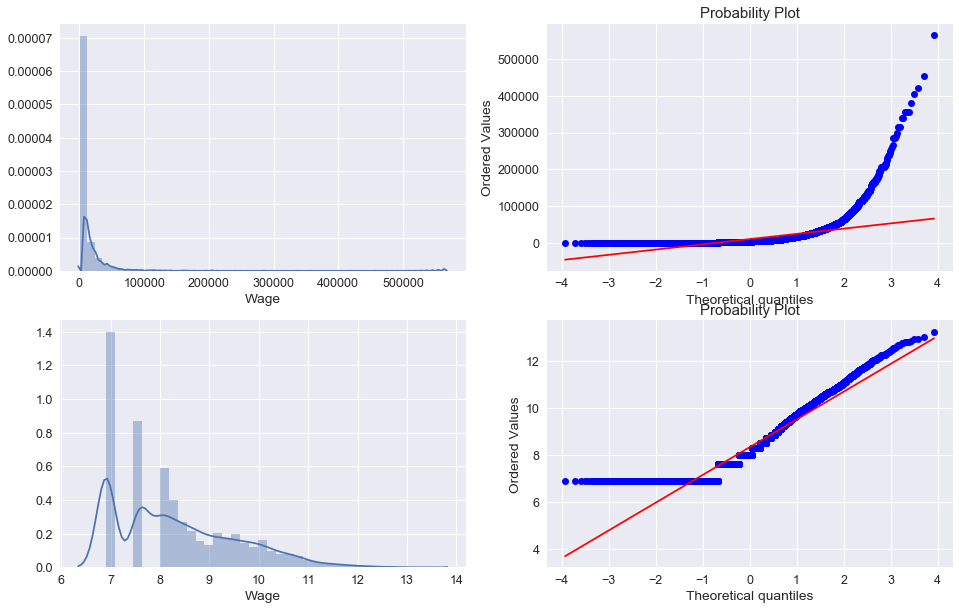

In [61]:
plt.subplots(figsize=(16,10))
plt.subplot(221)
sns.distplot(fifa.Wage)
print('Wage skew: ',fifa.Wage.skew())

plt.subplot(223)
w=np.log1p(fifa['Wage'])
sns.distplot(w)
print('Wage skew: ',w.skew())

plt.subplot(222)
stats.probplot(fifa.Wage, plot=plt)

plt.subplot(224)
stats.probplot(w, plot=plt)


plt.show()

In [23]:
# removing outliers from VALUE and Wage columns
q1wage=fifa.Wage.quantile(0.25)
q3wage=fifa.Wage.quantile(0.75)
iqrwage= q3wage - q1wage

q1val=fifa.VALUE.quantile(0.25)
q3val=fifa.VALUE.quantile(0.75)
iqrval= q3val - q1val

upperwage= q3wage + iqrwage*1.5
upperval= q3val + iqrval*1.5

fifa=fifa[(fifa.Wage <= upperwage) & (fifa.VALUE <= upperval)]

In [24]:
fifa.head()

,CAM,CB,CDM,CF,CM,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST,High,Low,Medium,High,Low,Medium,Lean,Normal,Stocky,Left,Right,Age,Overall,Potential,Wage,Special,InternationalReputation,WeakFoot,SkillMoves,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Forward,Midfield,Defense,GoalKeeper,VALUE
542,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,34,80,80,1000,2044,2.0,3.0,3.0,5.9,154.0,67.0,61.0,59.0,80.0,60.0,73.0,62.0,54.0,74.0,78.0,67.0,65.0,77.0,76.0,76.0,71.0,70.0,86.0,64.0,63.0,88.0,80.0,64.0,72.0,62.0,77.0,81.0,81.0,73.0,68.875,73.125,76.1,12.0,4500000
547,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,34,80,80,20000,1973,4.0,3.0,2.0,5.9,161.0,63.0,42.0,66.0,79.0,51.0,58.0,63.0,50.0,75.0,80.0,69.0,62.0,72.0,79.0,78.0,76.0,80.0,76.0,72.0,55.0,88.0,85.0,51.0,68.0,60.0,81.0,78.0,81.0,82.0,63.250,68.875,77.3,6.8,4500000
725,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,37,79,79,23000,2047,2.0,4.0,4.0,5.7,159.0,80.0,68.0,43.0,86.0,69.0,78.0,83.0,80.0,87.0,82.0,54.0,38.0,68.0,73.0,81.0,77.0,72.0,61.0,65.0,76.0,87.0,66.0,63.0,86.0,85.0,80.0,65.0,67.0,60.0,70.125,76.000,68.6,9.4,4000000
905,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,33,77,77,22000,1860,2.0,3.0,2.0,6.2,181.0,45.0,54.0,76.0,71.0,59.0,51.0,67.0,77.0,72.0,70.0,34.0,35.0,52.0,69.0,50.0,76.0,76.0,67.0,90.0,65.0,84.0,77.0,52.0,50.0,65.0,66.0,75.0,78.0,73.0,58.500,60.125,70.7,10.0,3600000
911,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,35,77,77,23000,1914,2.0,2.0,4.0,5.9,159.0,77.0,76.0,70.0,76.0,72.0,82.0,80.0,64.0,72.0,78.0,68.0,69.0,66.0,78.0,73.0,77.0,54.0,54.0,72.0,74.0,61.0,29.0,81.0,77.0,80.0,80.0,40.0,30.0,28.0,76.000,73.500,53.3,11.2,4099999


In [21]:
fifa1= fifa.copy()

In [25]:
Y=np.log(fifa.VALUE)
X=fifa.drop(['VALUE'], axis=1)
#X = pd.get_dummies(X)

In [26]:
# Normalizing dataset
from sklearn.preprocessing import MinMaxScaler

ms=MinMaxScaler()
X = ms.fit_transform(X)

In [27]:
#Splitting into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=32)

In [28]:
#Applying Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
predy = model.predict(X_test)
predx = model.predict(X_train)

#Finding the r2 score and root mean squared error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#print("lr.coef_: {}".format(model.coef_))
#print("lr.intercept_: {}".format(model.intercept_))

train_rmse= np.sqrt(mean_squared_error(np.exp(y_train), np.exp(predx)))
train_r2 = model.score(X_train, y_train)
test_rmse= np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predy)))
test_r2 = model.score(X_test, y_test)

Train_adjusted_r2 = 1 - ((1 - train_r2)*((X_train.shape[0] - 1)/(X_train.shape[0]-(X_train.shape[1]+1))))
Test_adjusted_r2= 1 - ((1 - test_r2)*((X_test.shape[0] - 1)/(X_test.shape[0]-(X_test.shape[1]+1))))

print(f'Train (R-Squared): {train_r2:0.4f}; || Train Adj_R-Squared: {Train_adjusted_r2:0.4f}')
print(f'Test  (R-Squared): {test_r2:0.4f}; || Test Adj_R-Squared:  {Test_adjusted_r2:0.4f}')
#print("Train (R-Squared): {:.3f}".format(model.score(X_train, y_train)))
#print("Test set score: {:.7f}".format(model.score(X_test, y_test)))
#print('Test  (R-Squared): '+str(r2_score(y_test, predy)))
#print('Test  (RMSE): '+str(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predy)))))
#print('Train (RMSE): '+str(np.sqrt(mean_squared_error(np.exp(y_train), np.exp(predx)))))
print('RMSE on train:',train_rmse)
print('RMSE on test_:',test_rmse)
print(f'RMSE difference(test-train): {test_rmse-train_rmse}')
print("Mean Absolute Error(MAE): ",mean_absolute_error(np.exp(y_test), np.exp(predy)))

Train (R-Squared): 0.9618; || Train Adj_R-Squared: 0.9615
Test  (R-Squared): 0.9594; || Test Adj_R-Squared:  0.9581
RMSE on train: 309740.0423893435
RMSE on test_: 286562.1492282842
RMSE difference(test-train): -23177.8931610593
Mean Absolute Error(MAE):  150574.84303484933


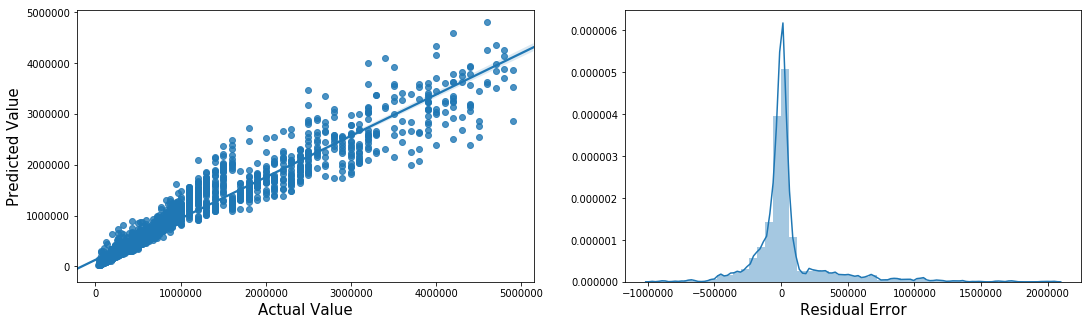

In [30]:
plt.subplots(figsize=(18,5))
plt.subplot(121)
sns.regplot(np.exp(y_test), np.exp(predy), scatter=True)
plt.ylabel('Predicted Value', fontsize=15)
plt.xlabel('Actual Value', fontsize=15)

plt.subplot(122)
sns.distplot(np.exp(y_test)-np.exp(predy))
plt.xlabel('Residual Error', fontsize=15)

plt.show()

In [35]:
result = pd.DataFrame({'Actual_Value': np.exp(y_test), 'Predicted_Value': np.exp(predy)})
result.Predicted_Value = result.Predicted_Value.astype('int64')
result.Actual_Value = result.Actual_Value.astype('int64')
result['Difference'] = result.Actual_Value - result.Predicted_Value
#result.insert(loc=0,column='Name',value=np.nan)

In [38]:
result.shape

(2671, 3)

In [40]:
from sklearn.linear_model import Lasso
model = Lasso()
model.fit(X_train, y_train)
predy = model.predict(X_test)
predx = model.predict(X_train)

train_rmse= np.sqrt(mean_squared_error(np.exp(y_train), np.exp(predx)))
train_r2 = model.score(X_train, y_train)
test_rmse= np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predy)))
test_r2 = model.score(X_test, y_test)

Train_adjusted_r2 = 1 - ((1 - train_r2)*((X_train.shape[0] - 1)/(X_train.shape[0]-(X_train.shape[1]+1))))
Test_adjusted_r2= 1 - ((1 - test_r2)*((X_test.shape[0] - 1)/(X_test.shape[0]-(X_test.shape[1]+1))))

print(f'Train (R-Squared): {train_r2:0.4f}; || Train Adj_R-Squared: {Train_adjusted_r2:0.4f}')
print(f'Test  (R-Squared): {test_r2:0.4f}; || Test Adj_R-Squared:  {Test_adjusted_r2:0.4f}')
#print("Train (R-Squared): {:.3f}".format(model.score(X_train, y_train)))
#print("Test set score: {:.7f}".format(model.score(X_test, y_test)))
#print('Test  (R-Squared): '+str(r2_score(y_test, predy)))
#print('Test  (RMSE): '+str(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predy)))))
#print('Train (RMSE): '+str(np.sqrt(mean_squared_error(np.exp(y_train), np.exp(predx)))))
print('RMSE on train:',train_rmse)
print('RMSE on test_:',test_rmse)
print(f'RMSE difference(test-train): {test_rmse-train_rmse}')
print("Mean Absolute Error(MAE): ",mean_absolute_error(np.exp(y_test), np.exp(predy)))

Train (R-Squared): 0.0000; || Train Adj_R-Squared: -0.0075
Test  (R-Squared): -0.0007; || Test Adj_R-Squared:  -0.0317
RMSE on train: 1060997.2736656086
RMSE on test_: 1004267.3010560822
RMSE difference(test-train): -56729.97260952636
Mean Absolute Error(MAE):  608166.3914570665


In [41]:
from sklearn.linear_model import Ridge
model = Ridge()
model.fit(X_train, y_train)
predy = model.predict(X_test)
predx = model.predict(X_train)

train_rmse= np.sqrt(mean_squared_error(np.exp(y_train), np.exp(predx)))
train_r2 = model.score(X_train, y_train)
test_rmse= np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predy)))
test_r2 = model.score(X_test, y_test)

Train_adjusted_r2 = 1 - ((1 - train_r2)*((X_train.shape[0] - 1)/(X_train.shape[0]-(X_train.shape[1]+1))))
Test_adjusted_r2= 1 - ((1 - test_r2)*((X_test.shape[0] - 1)/(X_test.shape[0]-(X_test.shape[1]+1))))

print(f'Train (R-Squared): {train_r2:0.4f}; || Train Adj_R-Squared: {Train_adjusted_r2:0.4f}')
print(f'Test  (R-Squared): {test_r2:0.4f}; || Test Adj_R-Squared:  {Test_adjusted_r2:0.4f}')
#print("Train (R-Squared): {:.3f}".format(model.score(X_train, y_train)))
#print("Test set score: {:.7f}".format(model.score(X_test, y_test)))
#print('Test  (R-Squared): '+str(r2_score(y_test, predy)))
#print('Test  (RMSE): '+str(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predy)))))
#print('Train (RMSE): '+str(np.sqrt(mean_squared_error(np.exp(y_train), np.exp(predx)))))
print('RMSE on train:',train_rmse)
print('RMSE on test_:',test_rmse)
print(f'RMSE difference(test-train): {test_rmse-train_rmse}')
print("Mean Absolute Error(MAE): ",mean_absolute_error(np.exp(y_test), np.exp(predy)))

Train (R-Squared): 0.9616; || Train Adj_R-Squared: 0.9613
Test  (R-Squared): 0.9591; || Test Adj_R-Squared:  0.9579
RMSE on train: 313665.22142183123
RMSE on test_: 290134.0845388641
RMSE difference(test-train): -23531.13688296714
Mean Absolute Error(MAE):  151138.1482864529


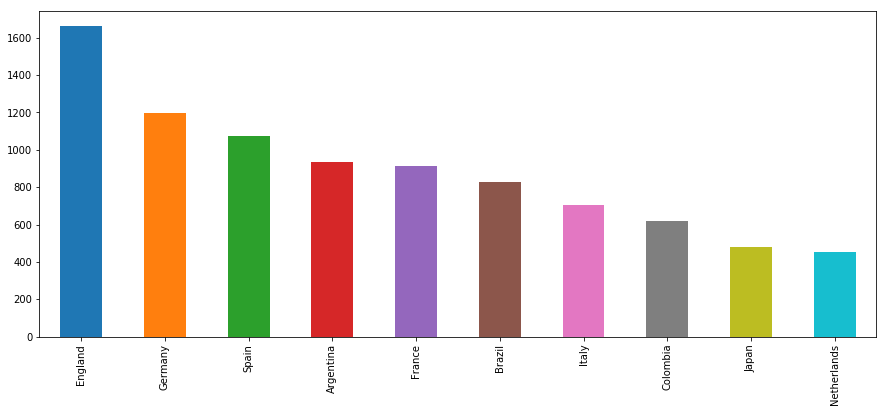

In [11]:
plt.figure(1 , figsize = (15 , 6))

fifa['Nationality'].value_counts()[:10].plot.bar()

In [18]:
fifa.sort_values(by = 'Age' , ascending = False)[['Name','Club','Nationality'
                                               ,'Overall', 'Age' ]].head(5)

,Name,Club,Nationality,Overall,Age
4741,O. Pérez,Pachuca,Mexico,71,45
18183,K. Pilkington,Cambridge United,England,48,44
17726,T. Warner,Accrington Stanley,Trinidad & Tobago,53,44
10545,S. Narazaki,Nagoya Grampus,Japan,65,42
7225,C. Muñoz,CD Universidad de Concepción,Argentina,68,41


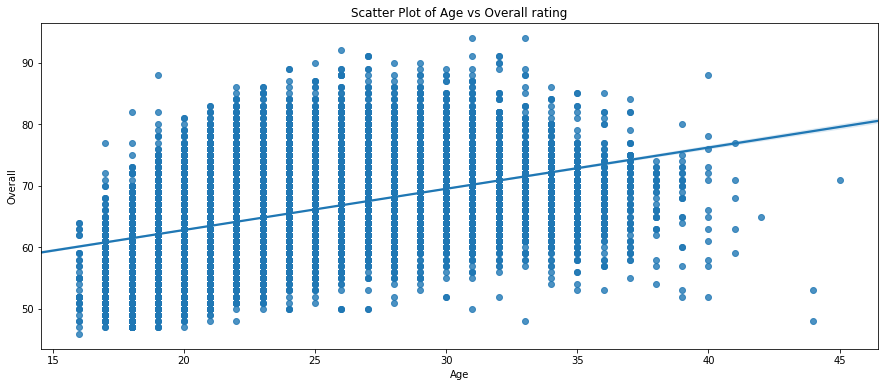

In [19]:
plt.figure(1 , figsize = (15 , 6))
sns.regplot(fifa['Age'] , fifa['Overall'])
plt.title('Scatter Plot of Age vs Overall rating')
plt.show()

In [24]:
from collections import Counter

In [27]:
c = Counter(fifa['Nationality']).most_common()[:11]

In [28]:
c

[('England', 1662),
 ('Germany', 1198),
 ('Spain', 1072),
 ('Argentina', 937),
 ('France', 914),
 ('Brazil', 827),
 ('Italy', 702),
 ('Colombia', 618),
 ('Japan', 478),
 ('Netherlands', 453),
 ('Sweden', 397)]

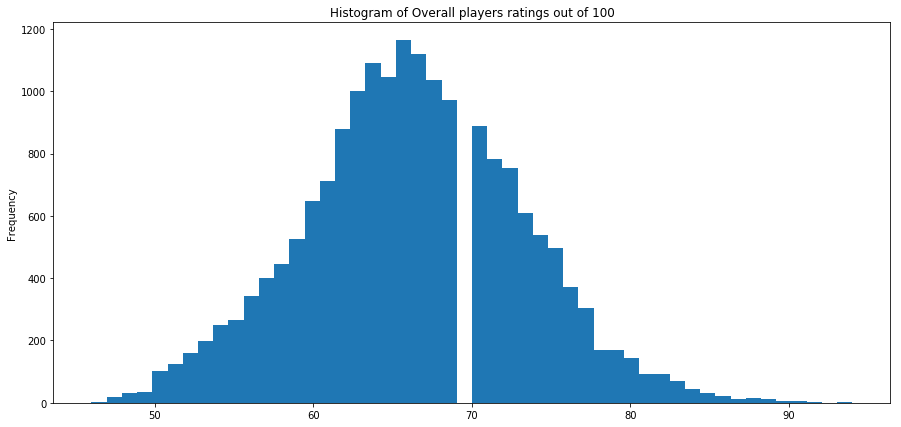

In [29]:
plt.figure(1 , figsize = (15 , 7))
fifa['Overall'].plot(kind = 'hist' , bins = 50 )
plt.title('Histogram of Overall players ratings out of 100')
plt.show()

In [36]:
best_players = pd.DataFrame(fifa.sort_values(by = 'Overall',ascending = False ).head(20))
best_players

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
5,5,183277,E. Hazard,27,https://cdn.sofifa.org/players/4/19/183277.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,91,Chelsea,https://cdn.sofifa.org/teams/2/light/5.png,€93M,€340K,2142,Right,4.0,4.0,4.0,High/ Medium,Normal,Yes,LF,10.0,"Jul 1, 2012",NaN,2020,5'8,163lbs,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,82+3,82+3,82+3,8

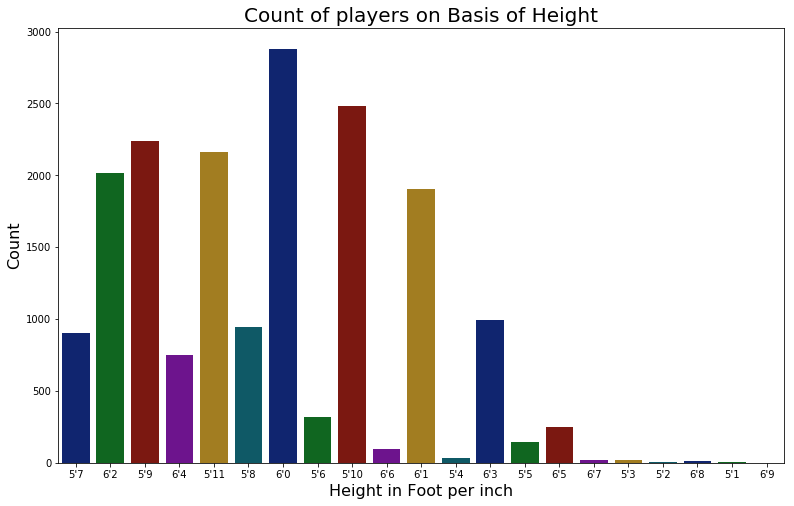

In [39]:
plt.figure(figsize = (13, 8))
ax = sns.countplot(x = 'Height', data = fifa, palette = 'dark')
ax.set_title(label = 'Count of players on Basis of Height', fontsize = 20)
ax.set_xlabel(xlabel = 'Height in Foot per inch', fontsize = 16)
ax.set_ylabel(ylabel = 'Count', fontsize = 16)
plt.show()

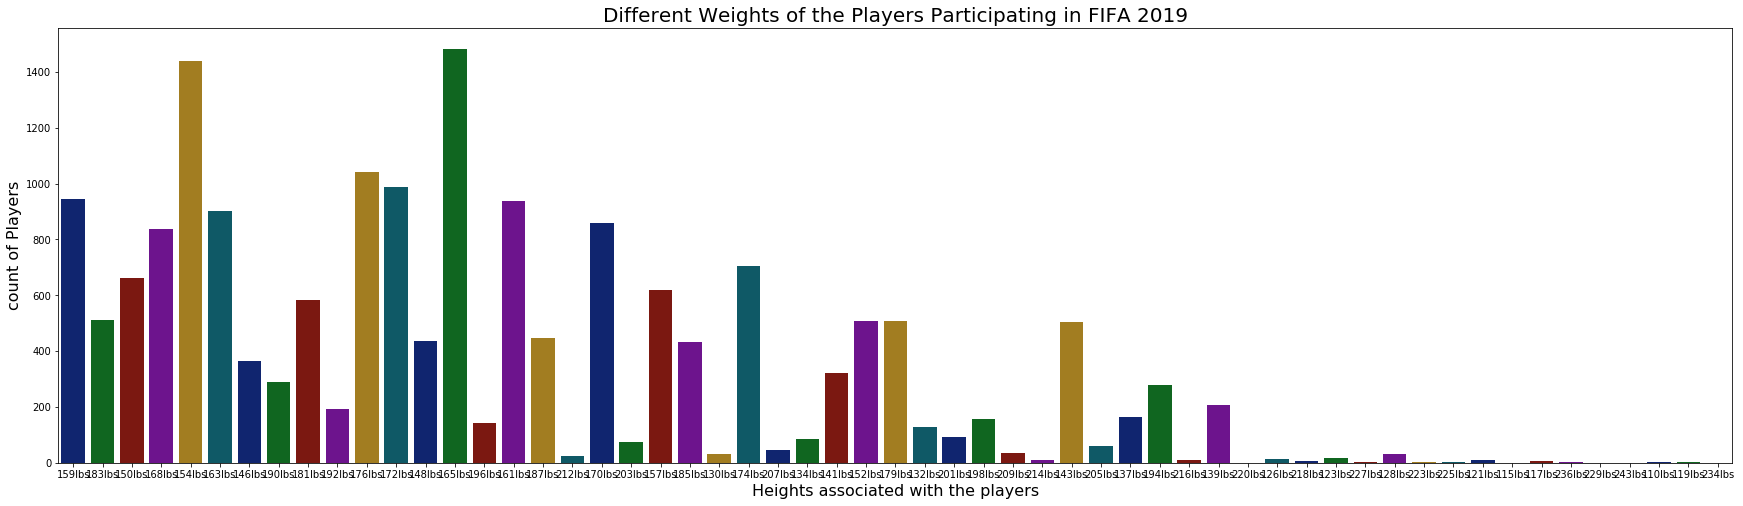

In [40]:
plt.figure(figsize = (30, 8))
sns.countplot(x = 'Weight', data = fifa, palette = 'dark')
plt.title('Different Weights of the Players Participating in FIFA 2019', fontsize = 20)
plt.xlabel('Heights associated with the players', fontsize = 16)
plt.ylabel('count of Players', fontsize = 16)
plt.show()

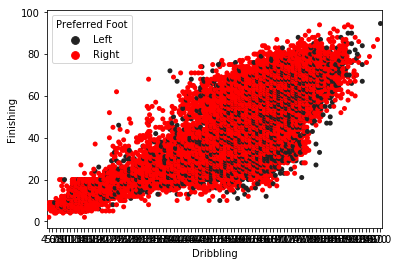

In [42]:
sns.swarmplot(x="Dribbling", y="Finishing",hue="Preferred Foot",data = fifa, color = 'red')
plt.show()

In [43]:
fifa.VALUE.skew()

1.9532770236444463

In [44]:
fifa.Wage.skew()

1.9291593369316467